In [39]:
import os
import nltk
import base64
from base64 import b64encode, b64decode
import uuid
from IPython.display import display, HTML
from unstructured.partition.pdf import partition_pdf
from operator import itemgetter

from langchain_core.documents import Document
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.retrievers import BaseRetriever
from langchain_core.documents import Document
from langchain_core.callbacks import CallbackManagerForRetrieverRun
from langchain_core.stores import BaseStore
from pydantic import Field
from typing import List

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage
from langchain_core.stores import InMemoryStore
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_chroma import Chroma

In [2]:
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [3]:
file_path = './data/mal_sample.pdf'

In [4]:
raw_pdf_elements = partition_pdf(
    filename=file_path,
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy='by_title',
    extract_image_block_output_dir='./data/mal_sample_picture'
)

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [5]:
tables = []
texts = []

for element in raw_pdf_elements:
    if 'unstructured.documents.elements.Table' in str(type(element)):
        tables.append(str(element))
    elif 'unstructured.documents.elements.CompositeElement' in str(type(element)):
        texts.append(str(element))

In [6]:
print(tables[0])
print('-----------')
print(tables[1])
print('-----------')
print(texts[0])
print('-----------')
print(texts[1])

202314 (1. 1.~12. 31.) A CHHI(4278) 20234 (1. 1.~10. 21.) (1. 202414 1.~10. 19.) Ail 673 (100) 663 (100.0) 630 (100.0) 5.0% ae tt 569 (84.5) 560 (84.5) 526 (83.5) 16.1% OfAt 104 (15.5) 108 (15.5) 104 (16.5) 1.0% we 0-94] 5 (0.7) 5 (0.8) 2( 0.3) 460.0% 10-194 31 ( 4.6) 30 ( 4.5) 20 ( 3.2) A33.3% 20-29M 201 (29.9) 200 (30.2) 209 (33.2) 4.5% 30-39M| 111 (16.5) 110 (16.6) 90 (14.3) A18.2% 40-494 107 (15.9) 104 (15.7) 96 (15.2) AT.7%
-----------
50-59M| 60-69M| (17.5) 63 ( 9.4) (17.3) 62 ( 9.4) (15.7) 73 (11.6) 17.7% JOH) Olt 37 ( 4.2) 37 ( 5.6) 41 ( 6.5) 10.8% 70¥)0|2f coc 50-594 40-494] 320-394 20-298 10-194] 0-94 200 EOL 180 160 140 == Ee —EEa i Yl | 120 100 80 60 40 20 0 was(m) = | 20 TOMS ae esi 0-594 50-594 40-4944 30-394 10-194] 0-34 200 180 160 140 120 100 #0 60 aa(8) [Ea a ——T —==y 20-255 40 20 nn mE l 0 20 (202314 4225) (202414 4228)
-----------
42주차 (10.13.~10.19.)

| Suyztay | aygises zt | Bail

주차

국내발생 해외유입

전체
-----------
1주~42주 665명 630명 35명 말라리아 환자 발생 현황 ’24년 1주부터 42주까지 말라리

In [7]:
prompt_text = '''당신은 표와 텍스트를 요약하여 검색할 수 있도록 돕는 역할을 맡은 어시스턴트입니다.
이 요약은 임베딩되어 원본 텍스트나 표 요소를 검색하는 데 사용될 것입니다.
표 또는 텍스트에 대한 간결한 요약을 제공하여 검색에 최적화된 형태로 만들어 주세요.
표 또는 텍스트: {element}'''

prompt = ChatPromptTemplate.from_template(prompt_text)
model = ChatOpenAI(model='gpt-5-nano', temperature=0)
summarize_chain = (
    {'element': lambda x: x}
    | prompt
    | model
    | StrOutputParser()
)

In [8]:
text_summaries = summarize_chain.batch(texts, {'max_concurrency':5})
table_summaries = summarize_chain.batch(tables, {'max_concurrency':5})

In [9]:
print(table_summaries[0])
print('---------')
print(table_summaries[1])
print('---------')
print(text_summaries[0])
print('---------')
print(text_summaries[1])

다음은 검색용으로 간결하게 정리한 표 요약입니다. 세 기간(세트) 간의 범주별 수치와 각 항목의 비율을 포함합니다. 주의: 일부 라벨은 원문에서 불완전하게 보입니다(Ail, ae tt, we 0-94], 40-494 등).

- 합계(All): 673 (100.0%), 663 (100.0%), 630 (100.0%); 변동률 5.0%
- ae tt: 569 (84.5%), 560 (84.5%), 526 (83.5%); 변동률 16.1%
- OfAt: 104 (15.5%), 108 (15.5%), 104 (16.5%); 변동률 1.0%
- we 0-94]: 5 (0.7%), 5 (0.8%), 2 (0.3%); 변동률 460.0%
- 10-194: 31 (4.6%), 30 (4.5%), 20 (3.2%); 변동률 33.3%
- 20-29M: 201 (29.9%), 200 (30.2%), 209 (33.2%); 변동률 4.5%
- 30-39M: 111 (16.5%), 110 (16.6%), 90 (14.3%); 변동률 18.2%
- 40-49(40-494로 표기): 107 (15.9%), 104 (15.7%), 96 (15.2%); 변동률 약 7% (표기상 차이 반영)

요약 포인트
- 전체적으로 각 기간의 합계는 673/663/630으로 유사한 규모를 유지.
- 상위 범주 중 ae tt가 가장 큰 점유율(약 84–85%)을 차지.
- 연령대 분포는 20–29M이 가장 크고(약 30%대), 30–39M이 다소 낮아짐.
- 기간 간 변화율은 항목별로 크게 다름(일부 항목은 큰 증가나 감소를 보이는 구간 있음).

필요하시면 위를 JSON형태나 특정 키워드 중심의 초간단 인덱스 형태로도 제공해 드리겠습니다.
---------
요약(검색 최적화용)

- 데이터 유형: 표/그래프 혼합 형태의 수치 데이터로 보이나 헤더가 손상되어 해석이 불완전합니다.
- 주제/대상: 남성(M), 연령대 비교 = 50-59세(M) 대 60-69세(M).
- 핵심 수치 형태: 여러 값이 한 줄

In [10]:
def encode_image(image_path):
    with open(image_path, 'rb') as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

In [11]:
img_base64_list = []
img_dir_path = './data/mal_sample_picture'

for img_file in sorted(os.listdir(img_dir_path)):
    if img_file.endswith('.jpg') or img_file.endswith('png'):
        img_path = os.path.join(img_dir_path, img_file)
        base64_image = encode_image(img_path)
        img_base64_list.append(base64_image)

In [12]:
def image_summarize(img_base64: str) -> str:
    chat = ChatOpenAI(model='gpt-5-nano', max_completion_tokens=1024)
    prompt = '''당신은 이미지를 요약하여 검색을 위해 사용할 수 있도록 돕는 어시스턴트입니다.
    이 요약은 임베딩되어 원본 이미지를 검색하는 데 사용됩니다.
    이미지 검색에 최적화된 간결한 요약을 작성하세요.'''

    msg = chat.invoke(
        [HumanMessage(
            content=[{'type':'text', 'text':prompt},
                     {'type':'image_url', 'image_url':{'url':f'data:image/jpeg;base64,{img_base64}'}}]
        )]
    )

    return msg.content

In [13]:
image_summaries = []

for img_base64 in img_base64_list:
    image_summary = image_summarize(img_base64)
    image_summaries.append(image_summary)

In [14]:
for image_summary in image_summaries:
    print(image_summary)
    print('-------------------')


-------------------
요약:
원형의 파란색 그라데이션 배경에 중앙에 흰색 재생 삼각형이 있는 비디오 재생 버튼 아이콘.

키워드:
재생 버튼, 원형 아이콘, 파란 그라데이션, 흰색 삼각형, 비디오 재생, 미디어 컨트롤, UI 아이콘, 플레이 아이콘
-------------------

-------------------

-------------------
한국어 UI의 요약 배너: 파란-보라 색상, 왼쪽에 큰 '요약' 텍스트, 오른쪽에 3개 원형 아이콘, 얇은 파란 테두리 프레임.
-------------------

-------------------

-------------------
파란 원형 재생 아이콘(흰색 삼각형), 비디오 플레이어 UI 요소, 그라데이션 블루 배경
-------------------
파란색 원형 배경에 흰색 재생 삼각형 아이콘—미디어 재생 버튼.
-------------------
파란색 그라데이션 원형 배경에 중앙 흰색 재생 삼각형 아이콘이 있는 미디어 재생 버튼.
-------------------
Circular blue-gray play button icon with a white triangle (video/player UI).
-------------------

-------------------

-------------------
말라리아 환자 발생 현황 — 한국어 인포그래픽 제목, 파란색 곡선형 배너에 좌측 원형 ‘1’ 배지, 말라리아 발생/사례 현황과 건강 통계 주제.
-------------------
파란 원형 재생 아이콘(흰색 삼각형) — 비디오 재생 버튼.
-------------------

-------------------

-------------------

-------------------

-------------------

-------------------

-------------------

-------------------

-------------------

In [15]:
class MultiVectorRetriever(BaseRetriever):
    vectorstore: any = Field(description="요약본을 검색할 벡터 저장소")
    docstore: BaseStore = Field(description="원본 문서를 저장하는 키-값 저장소")
    id_key: str = Field(default="doc_id", description="문서 ID를 저장한 메타데이터 키")

    def _get_relevant_documents(
        self, query: str, *, run_manager: CallbackManagerForRetrieverRun
    ) -> List[Document]:
        # 1. 벡터 스토어에서 요약본을 검색합니다. (유사도 검색)
        sub_docs = self.vectorstore.similarity_search(query)
        
        # 2. 검색된 요약본들의 메타데이터에서 'doc_id'를 추출합니다.
        ids = []
        for d in sub_docs:
            if self.id_key in d.metadata:
                ids.append(d.metadata[self.id_key])
        
        # 3. 추출한 ID를 사용해 docstore에서 '원본 문서'를 가져옵니다.
        # (mget은 여러 개의 ID로 한 번에 값을 가져오는 메서드입니다)
        docs = self.docstore.mget(ids)
        
        # 4. None(찾지 못한 경우)을 제외하고 반환합니다.
        return [d for d in docs if d is not None]

c:\Coding\Local\exercise_book_ver2\.venv\Lib\site-packages\pydantic\_internal\_generate_schema.py:648: ArbitraryTypeWarning: <built-in function any> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warnings.warn(


In [16]:
vectordb = Chroma(collection_name='multi_modal_rag', embedding_function=OpenAIEmbeddings())
docstore = InMemoryStore()
id_key = 'doc_id'

In [17]:
retriever = MultiVectorRetriever(
    vectorstore=vectordb,
    docstore=docstore,
    id_key=id_key
)

In [20]:
doc_ids = [str(uuid.uuid4()) for _ in texts]
retriever.docstore.mset(list(zip(doc_ids, texts)))

table_ids = [str(uuid.uuid4()) for _ in tables]
retriever.docstore.mset(list(zip(table_ids, tables)))

img_ids = [str(uuid.uuid4()) for _ in img_base64_list]
retriever.docstore.mset(list(zip(img_ids, img_base64_list)))

In [21]:
summary_texts = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)

summary_tables = [
    Document(page_content=s, metadata={id_key: table_ids[i]})
    for i, s in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)

summary_img = [
    Document(page_content=s, metadata={id_key: img_ids[i]})
    for i, s in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)

['e967df9c-733f-42ec-84d0-cddd8750d66b',
 'e0bb8807-3f24-4ede-a5d9-932283af30b7',
 'bbdf5d8b-ad11-4caf-b19b-68f601898bdb',
 '821a4cb6-bd0d-4fd5-a96d-3f88e202b917',
 '5eb6dc87-cdd4-4031-8cef-baae1bcfc90b',
 '4cbee395-f572-41b5-93c1-8af0802a443a',
 '2a46ee58-d7c7-4d9e-b483-a3448d734dd0',
 '42f25d74-32b7-44a4-9724-8405f577a37f',
 '2031d8d1-f30c-4e4c-a3ab-99f75de0e8f8',
 '132b5756-2bc1-46b0-ae0d-5bfd5a4e4643',
 '5b014d85-c7e2-41fc-9b3a-728bcb2f5a30',
 'a33f4cb1-c302-40e1-a1b9-05e36126a39d',
 '2760bf6e-b73b-40dc-86a0-5c8a1af092f0',
 '8584822a-1cf0-4681-986a-a7cad3691dd3',
 '06a808bf-6999-41ff-9f91-0879dc138c86',
 '809b5438-8963-4f24-8242-c649a4eb5d08',
 '49ba1ee2-a4ee-407e-be45-c5a0779953b3',
 '1140177b-722a-4ec7-8629-ab49e2eecb4c',
 'a9e7b102-f637-4519-bc10-50f2c94bcb5d',
 '657b86b1-c8a4-4742-84e9-852bb2e3b4de',
 'cae347d9-e58e-46be-8772-dae8159607c3',
 '7c2bfa24-e1e5-4247-a498-d3d42aa5ca86',
 'c322e022-bebc-4a9b-858a-03adb2234420',
 'f1c9be64-ea4d-4a27-bbe1-81f119276cc8',
 '00109e15-8a3b-

In [22]:
docs = retriever.invoke('말라리아 군집 사례는 어떤가요?')
len(docs)

4

In [26]:
def split_image_text_types(docs):
    b64 = []
    text = []
    for doc in docs:
        try:
            base64.b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    
    return {'images':b64, 'texts':text}

In [29]:
docs_by_type = split_image_text_types(docs)
print(len(docs_by_type['images']), len(docs_by_type['texts']))

1 3



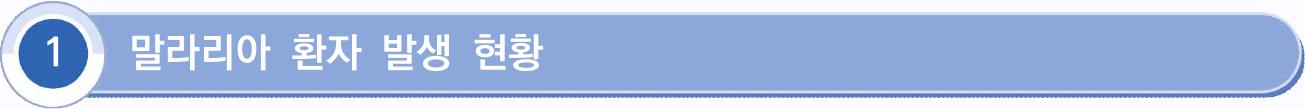

In [38]:
def plt_img_base64(img_base64):
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    display(HTML(image_html))

plt_img_base64(docs_by_type['images'][0])

In [ ]:
def prompt_func(dict):
    format_texts = "\n".join(dict["context"]["texts"])
    
    text_prompt = f"""다음 문맥에만 기반하여 질문에 답하세요. 문맥에는 텍스트, 표, 그리고 아래 이미지가 포함될 수 있습니다.
질문: {dict['question']}

텍스트와 표:
{format_texts}
"""
    
    content = [{"type": "text", "text": text_prompt}]
    if dict["context"]["images"]:
        for img_base64 in dict["context"]["images"]:
            content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                }
            )
    
    prompt = [HumanMessage(content=content)]
    
    return prompt

In [49]:
model = ChatOpenAI(model='gpt-4o-mini', temperature=0, max_completion_tokens=1024)

In [50]:
chain = (
    {'context':retriever | RunnableLambda(split_image_text_types), 'question':RunnablePassthrough()}
    | RunnableLambda(prompt_func)
    | model
    | StrOutputParser()
)

In [52]:
print(chain.invoke('말라리아 군집 사례는 어떤가요?'))

말라리아 군집 사례는 42주차(10.13.~10.19.) 동안 4개 시도에서 총 46건이 발생하였으며, 환자 수는 114명입니다. 군집사례는 위험지역 내에서 2명 이상의 환자가 증상 발생 간격이 14일 이내이고, 환자 거주지 거리가 1km 이내인 경우로 정의됩니다. 

각 시도별 군집사례는 다음과 같습니다:
- 서울: 1건(5명)
- 인천: 5건(10명)
- 경기: 39건(94명)
- 강원: 1건(5명)

특히 경기 지역에서 많은 군집사례가 발생하였으며, 파주시는 15건으로 가장 높은 수치를 기록했습니다.
